**3x3 DELAY EFFECT:** this notebook implements a 3 amplitude qubits by 3 time qubits delay for QSM scheme.


1. Import libraries:

In [5]:
import quantumaudio
from quantumaudio.tools import test_signal
from quantumaudio.tools import plot
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import PermutationGate

2. Generate signal and encode it:

Quantum State Modulation

Encoded Circuit:


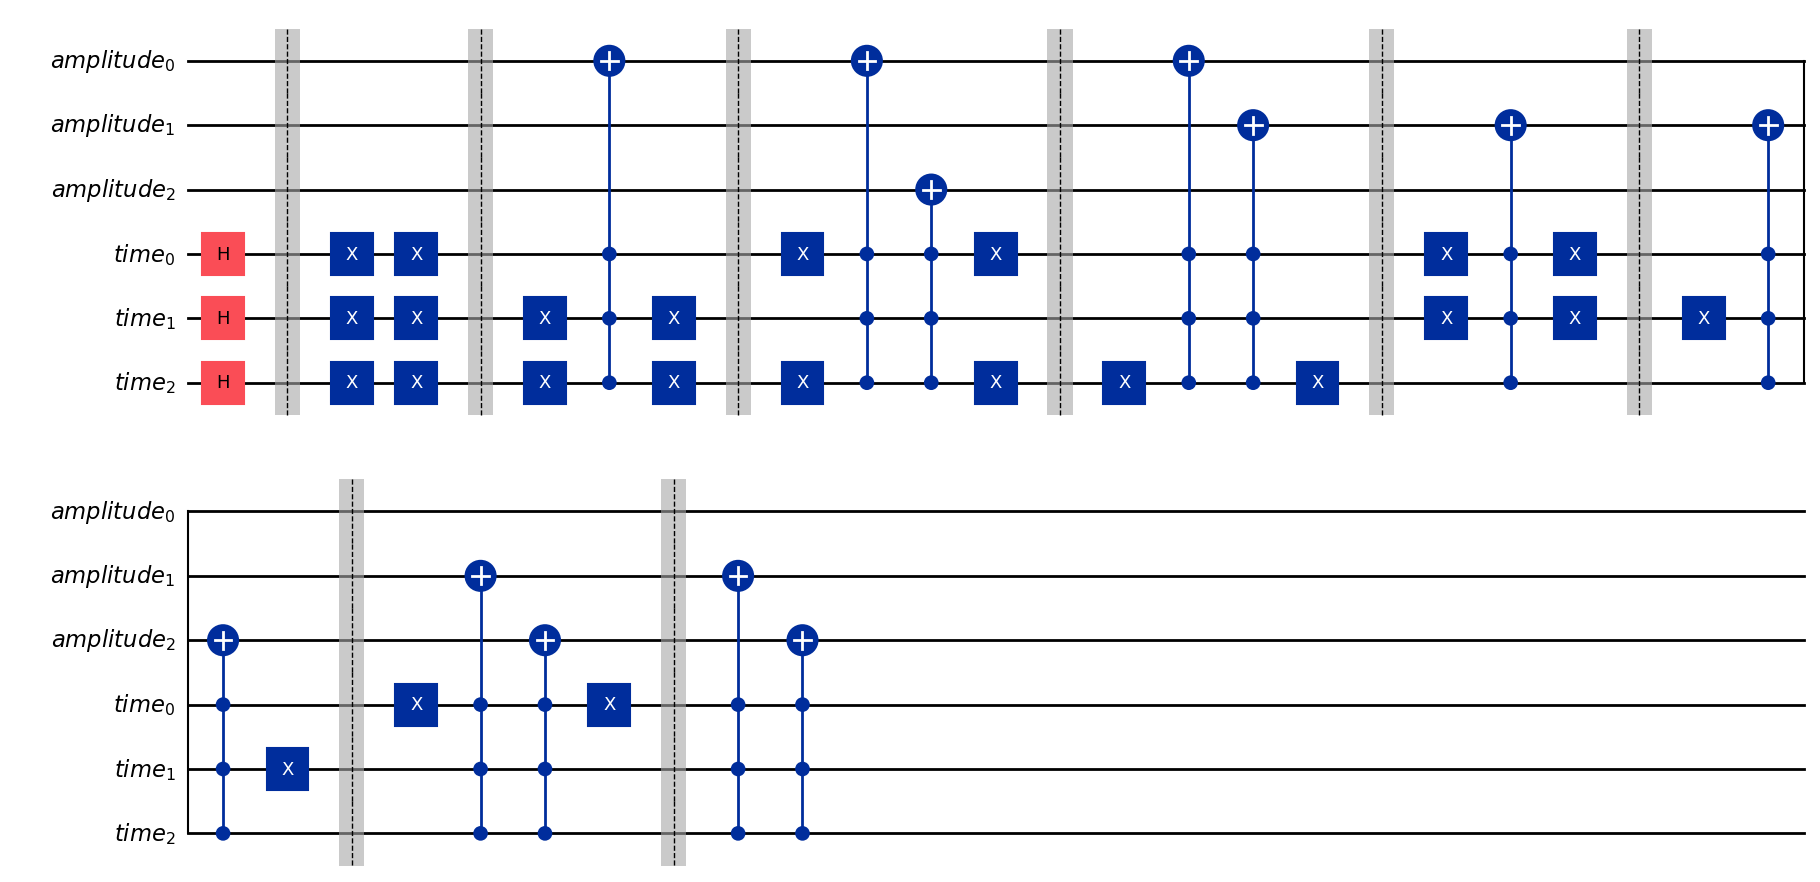

In [6]:
signal = test_signal(num_channels=1, num_samples=8)  # import test signal. 8 samples requires 3 qubits for the time
#signal[0:8] = [0.9, 0, 0, 0, 0, 0, 0, 0] # handcrafted signal
scheme = quantumaudio.load_scheme('qsm', qubit_depth=3)  # load the QSM scheme. qubit_depth=3 means 3 amplitude qubits
encoded_circuit = scheme.encode(signal, verbose=0, measure=False)
print("\nEncoded Circuit:")
encoded_circuit.draw(output='mpl')

2. Delay effect:


Encoded Circuit with Delay & Measurements:


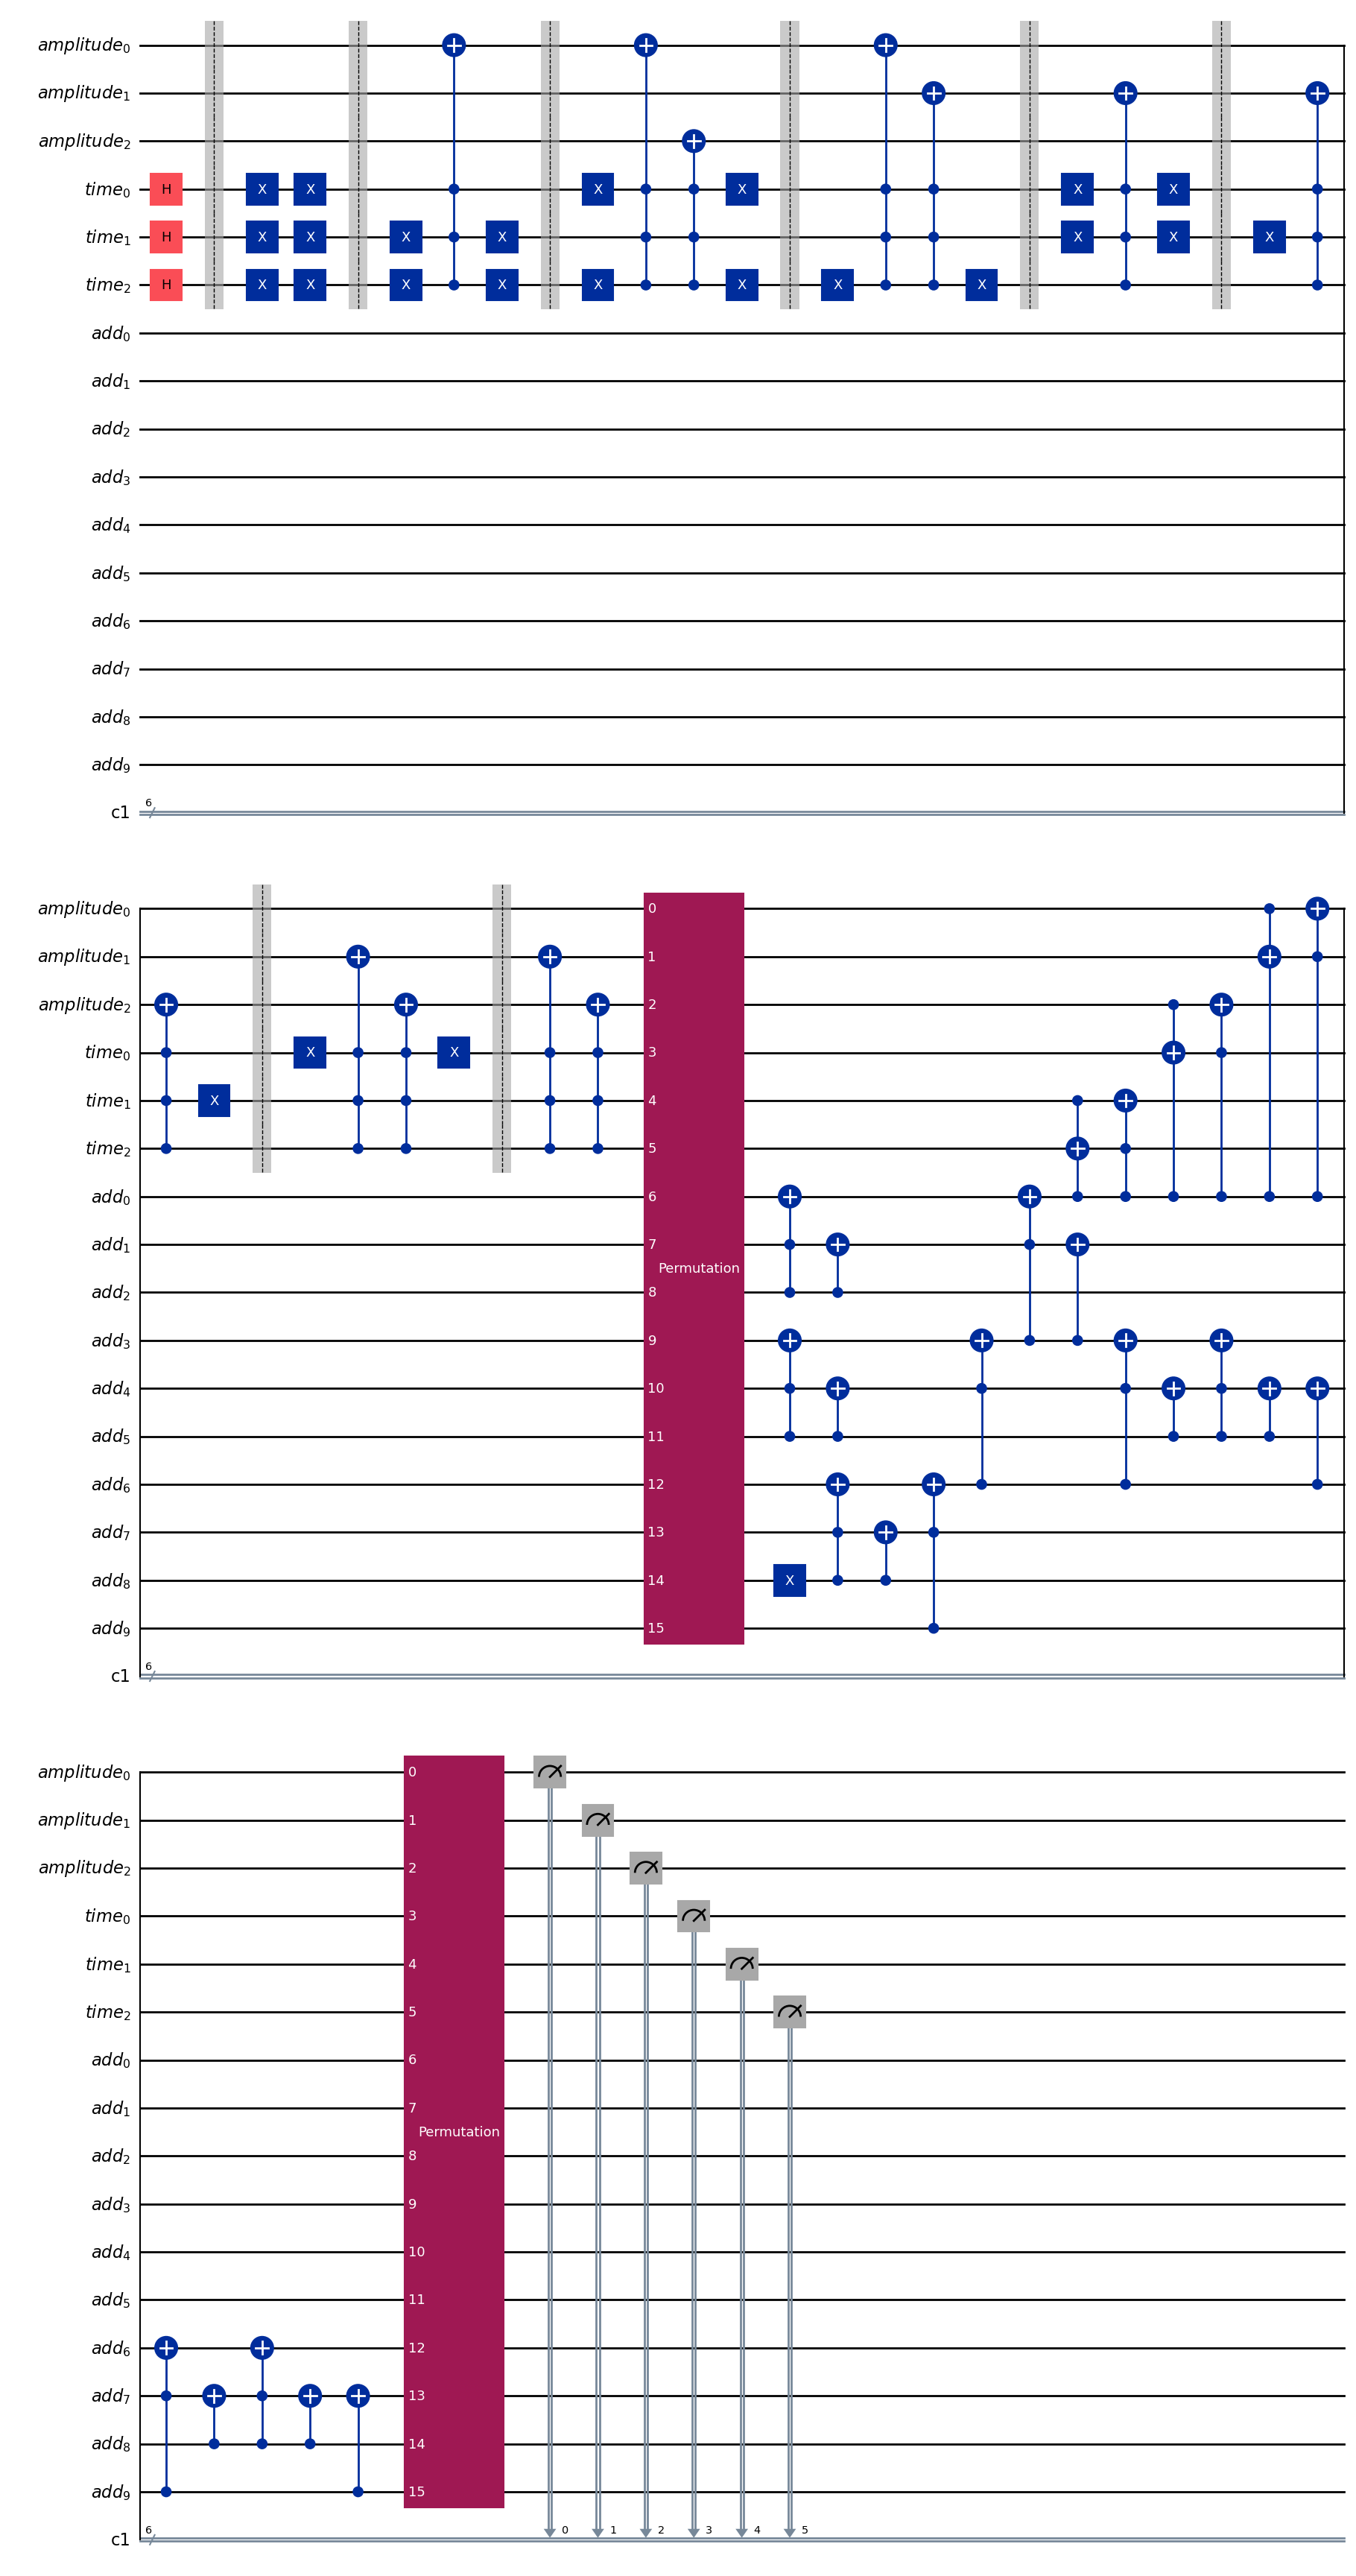

In [7]:
# --- ADD ANCILLAE QUBITS ---
n = 10 # number of additional ancilla qubits
encoded_circuit.add_register(QuantumRegister(n, name='add')) # add = additional qubits initialized to 0

# --- PERMUTATION ---
# Define the new order
new_order = [0, 2, 4, 13, 10, 7, 1, 3, 5, 6, 9, 12, 15, 8, 11, 14] # new order of qubits
perm_circuit = PermutationGate(new_order)
encoded_circuit.append(perm_circuit.inverse(), range(16)) # apply permutation gate

# --- DELAY: TIME ADDER CIRCUIT ---
# Original circuit with 11 qubits
n_qubits = 16
delay_circuit = QuantumCircuit(n_qubits)

# TIME INTERVAL SWITCHES

# One qubit shifts
#delay_circuit.x(8) # t1 = most significant bit --> this one activated shifts in 4
#delay_circuit.x(11) # t2 = middle bit --> this one activated shifts in 2
delay_circuit.x(14) # t3 = least significant bit --> this one activated shifts in 1

# Two qubit shifts
#delay_circuit.x([8,11]) # 6 samples delay
#delay_circuit.x([8,14]) # 5 samples delay
#delay_circuit.x([11,14]) # 3 samples delay

# Three qubit shift
#delay_circuit.x([8,11,14]) # 7 samples delay

# SECTION 1
# Define the sets of qubits (triplets) for the operations
triplets = [(14, 13, 12, 15), (11, 10, 9, 12), (8, 7, 6, 9)]
# Apply the operations in a loop
for ctrl1, ctrl2, target, next_ctrl in triplets:
    delay_circuit.ccx(ctrl1, ctrl2, target)
    delay_circuit.cx(ctrl1, ctrl2)
    delay_circuit.ccx(next_ctrl, ctrl2, target)

# SECTION 2
# Update the qubit indices
delay_circuit.cx(9, 7)

# SECTION 3
# Define the sets of qubits to operate on (excluding the first four)
qubit_sets = [(12, 10, 9, 11), (15, 13, 12, 14)]

# Apply the operations in a compact loop
for ctrl1, ctrl2, target, alt_ctrl in qubit_sets:
    delay_circuit.ccx(ctrl1, ctrl2, target)
    delay_circuit.cx(alt_ctrl, ctrl2)
    delay_circuit.ccx(alt_ctrl, ctrl2, target)
    delay_circuit.cx(alt_ctrl, ctrl2)
    delay_circuit.cx(ctrl1, ctrl2)   

# --- DELAY: SETTING AMPLITUDES THAT GO TO ZERO ---
# Define the target pairs for the ccx gates
target_pairs = [(4, 5), (5, 4), (2, 3), (3, 2), (0, 1), (1, 0)]
# Apply the ccx operations in a loop
for ctrl2, target in target_pairs:
    delay_circuit.ccx(6, ctrl2, target)

encoded_circuit = encoded_circuit.compose(delay_circuit)

# --- REVERSE PERMUTATION ---
encoded_circuit.append(perm_circuit, range(16))

# --- MEASUREMENTS ---
num_measurements = 6  # We want to measure the first 6 qubits
if encoded_circuit.num_clbits < num_measurements:
    encoded_circuit.add_register(ClassicalRegister(num_measurements - encoded_circuit.num_clbits))
# Measure only the first 6 qubits
encoded_circuit.measure(range(6), range(6)) # ([quantum register], [classical register])

print("\nEncoded Circuit with Delay & Measurements:")
encoded_circuit.draw(output='mpl')

4. Decoded signal and plot comparison:


Original Signal:
[ 0.20223002  0.41614516 -0.95883101  0.9398197   0.66488528 -0.57532178
 -0.63635007 -0.63319098]

Decoded Signal:
[ 0.    0.    0.25 -0.75  0.75  0.5  -0.5  -0.5 ]

Plots:


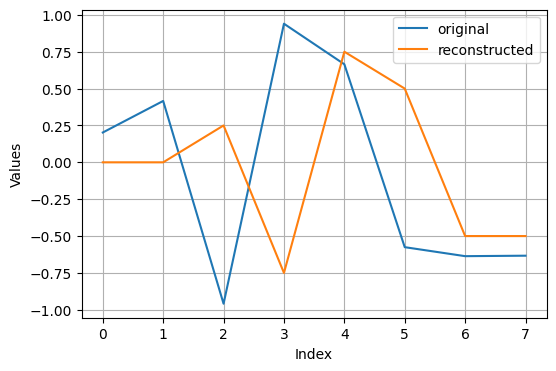

In [8]:
decoded_signal = scheme.decode(encoded_circuit)

print("\nOriginal Signal:")
print(signal)
print("\nDecoded Signal:")
print(decoded_signal)
print("\nPlot:")
plot([signal, decoded_signal])